In [1]:
import pandas as pd
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

##### *2. Please provide your justification for your choice of dataset.*

We'll go ahead with a dataset in `.parquet` format for the following reasons:
- it is optimised for working with big data and offers better performance than JSON, so we can perform reading and writing operations faster
- more storage efficient than JSON, since the latter is represented by plain text and lacks compression. 
- more widely adopted within Big Data frameworks, like Hadoop and Apache Spark. 

In [2]:
df = pd.read_parquet('../data/parquet')

In [3]:
df.head()

,epochMillis,mmsi,position,navigation,olson_timezone,vesselDetails,port,imo,callSign,destination,cargoDetails
0,1553580752000,414947474,"{'latitude': 30.471167, 'longitude': 122.275536}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'YI HANG JUN 136', 'typeName': 'Carg...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,YYYY,LONGKOU.,None
1,1553580863000,413777558,"{'latitude': 31.40998, 'longitude': 121.49894}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'CHEN YANG 18', 'typeName': 'Cargo', ...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,None,None
2,1553581142000,413791092,"{'latitude': 31.377872, 'longitude': 121.56676}","{'navCode': 16, 'navDesc': 'Unknown', 'courseO...",Asia/Shanghai,"{'name': 'XINAN020', 'typeName': 'Tanker', 'ty...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",NaN,None,None,None
3,1553581236000,413207250,"{'latitude': 31.249777, 'longitude': 121.77731}","{'navCode': 0, 'navDesc': 'Under Way Using Eng...",Asia/Shanghai,"{'name': 'LONGSHENG17', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,SHANGHAI,None
4,1553581407000,414350410,"{'latitude': 31.078783, 'longitude': 121.47187}","{'navCode': 5, 'navDesc': 'Moored', 'courseOve...",Asia/Shanghai,"{'name': 'SHUNHANG 79', 'typeName': 'Cargo', '...","{'unlocode': 'CNSHG', 'name': 'SHANGHAI PT', '...",0.0,None,ZHOUSHAN SHA,None


##### *3. What is(are) the main time period(s) in the data?*

In [4]:
timestamp = pd.to_datetime(df['epochMillis'], unit='ms').rename('timestamp')
min_date, max_date = timestamp.min(), timestamp.max()
print(f"Min date: {min_date}, Max date: {max_date}")

Min date: 2019-03-22 23:36:38, Max date: 2020-03-27 23:54:04


As we see, the dataset seems to encompass a bit more than 1 year. We may also explore the daily tendencies in the data.

In [5]:
date = timestamp.dt.date
daily = date.value_counts().sort_index().reset_index()
daily.columns = ['date', 'count']

In [6]:
chart = alt.Chart(daily).mark_bar().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('count:Q', title='Number of Records'),
    tooltip=['date:T', 'count:Q']
).properties(
    title='Data Density Over Time',
    width=800,
    height=400
)

chart

alt.Chart(...)

Although the min-max time range of our dataset could have implied that the data is distributed over more than a year, this is not the case, as we can observe from the above visualisation. 

##### *4. Which are the top three most sparse variables?*

In [7]:
missing_vals = df.isnull().mean() * 100
missing_vals_sort = missing_vals.sort_values(ascending=False)
top_sparse = missing_vals_sort.head(3)

for col in top_sparse.index:
    print(f"{col}: {missing_vals_sort[col]:.2f}%")

cargoDetails: 90.41%
imo: 42.34%
destination: 32.72%


In [8]:
missing_vals_sort = missing_vals_sort.reset_index()
missing_vals_sort.columns = ['variable', 'missing_percentage']

In [9]:
chart = alt.Chart(missing_vals_sort).mark_bar().encode(
    x=alt.X('variable', sort=None, title='Variable'),
    y=alt.Y('missing_percentage', title='Missing Percentage'),
    tooltip=['variable', 'missing_percentage']
).properties(
    title='Feature Sparsity',
    width=600,
    height=300
)

chart

alt.Chart(...)

In other words, there are 4 features with missing data: `cargoDetails`, `imo`, `destination` & `callSign`. Among these, the most sparse one is `cargoDetails` which contains only 10% of the records. Another sparse variables in top-3 are `imo` and `destination` (miss about 42 and 32% of the data correspondingly).

##### *5. What region(s) of the world and ocean port(s) does this data represent? Provide evidence to justify your answer.*

Perhaps the most straightforward thing here would be to check how many different timezones are present in the dataset.

In [10]:
df['olson_timezone'].unique()

array(['Asia/Shanghai'], dtype=object)

Only one unique entry is present which is Asia/Shanghai meaning that all the vessels from the dataset were shipped from ports located in this timezone. We might verify it by exploring a `port` column

In [11]:
ports = pd.DataFrame(df.port.tolist())
ports[['unlocode', 'name']].value_counts()

unlocode  name       
CNSHG     SHANGHAI PT    3473877
Name: count, dtype: int64

Indeed, we can see that all the vessels from the dataset were shipped from a single Chinese port: `SHANGHAI PT`. We may also observe the countries vessels are coming from by extracting `flagCountry` property from vessel details column.

In [12]:
vessel_details = pd.DataFrame(df.vesselDetails.tolist())
flag_counts = pd.DataFrame(vessel_details.flagCountry.value_counts()).reset_index()

In [13]:
print(f"Unique country flags: {flag_counts.shape[0]}")
flag_counts.head(10)

Unique country flags: 111


,flagCountry,count
0,China,3021932
1,Panama,91455
2,Hong Kong,86471
3,Liberia,52604
4,Marshall Islands,42723
5,Singapore,26636
6,Malta,19324
7,South Korea,18598
8,Madeira,8780
9,Belize,7833


Thus, vessels come from 111 different regions. However, this number does not represent distinct countries but may include regious within a country, since we can note that there are items like `Madeira` (an autonomous region in Portugal).

##### *6. Provide a frequency tabulation of the various Navigation Codes & Descriptions (i.e., navCode & NavDesc). Optionally, provide any additional statistics you find interesting.*

In [14]:
nav_details = pd.DataFrame(df.navigation.tolist())
code_desc_freq = nav_details.groupby(['navCode', 'navDesc']).size().reset_index(name='count')
code_desc_freq = code_desc_freq.sort_values(by='count', ascending=False)

In [15]:
code_desc_freq

,navCode,navDesc,count
14,16,Unknown,1357985
0,0,Under Way Using Engine,1063676
5,5,Moored,554133
1,1,At Anchor,426433
13,15,Not Defined,29330
8,8,Underway Sailing,24889
3,3,Restricted Manoeuvrability,8237
2,2,Not Under Command,3471
4,4,Constrained By Her Draught,1483
9,9,Reserved For Future Amendment,1359


The most frequent combination of `navCode` and `navDesc` properties is "16 + Unknown". Apart from "Unknown", there's also "Not defined" description category that only corresponds to `navCode` of 15. 

Apart from that, we can calculate frequency tabulation taking into account of `navDesc` and `flagCountry` categories.

In [16]:
flag_navDesc = pd.concat([vessel_details, nav_details], axis=1)
flag_navDesc_freq = flag_navDesc.groupby(['flagCountry', 'navDesc']).size().reset_index(name='count')
flag_navDesc_freq = flag_navDesc_freq.sort_values(by='count', ascending=False)
flag_navDesc_freq.head(10)

,flagCountry,navDesc,count
65,China,Unknown,1349134
63,China,Under Way Using Engine,914385
57,China,Moored,404391
54,China,At Anchor,294287
216,Panama,Under Way Using Engine,31540
212,Panama,Moored,30196
114,Hong Kong,At Anchor,29547
116,Hong Kong,Moored,28534
120,Hong Kong,Under Way Using Engine,27826
211,Panama,At Anchor,27707


Of course, it's now also possible to lookup specific countries

In [17]:
flag_navDesc_freq[flag_navDesc_freq['flagCountry'] == 'South Korea']

,flagCountry,navDesc,count
264,South Korea,Under Way Using Engine,10186
261,South Korea,At Anchor,5502
262,South Korea,Moored,2041
265,South Korea,Underway Sailing,556
266,South Korea,Unknown,285
263,South Korea,Not Under Command,28


We may also observe a relationship between nav description category and vessel length.

In [18]:
length_navDesc = pd.concat([vessel_details['length'], nav_details['navDesc']], axis=1)
mean_length_by_navDesc = mean_length_by_navDesc = length_navDesc.groupby('navDesc')['length'].mean().reset_index()
mean_length_by_navDesc = mean_length_by_navDesc.sort_values(by='length', ascending=False)

In [19]:
chart = alt.Chart(mean_length_by_navDesc).mark_bar().encode(
    x=alt.X('navDesc', sort=None, title='Description Category'),
    y=alt.Y('length', title='Vessel Length (m)'),
    tooltip=['navDesc', 'length']
).properties(
    title='Vessel Length by Navigation Description Category',
    width=1000,
    height=300
)

chart

alt.Chart(...)

##### *7. MMSI = 205792000*

In [20]:
# Helper functions
def prepare_df(df, nav_details, target_mmsi, top_navCodes, filter_period=None):
    filtered_df = pd.concat([df, nav_details[['navCode', 'navDesc']]], axis=1)
    filtered_df = filtered_df[(filtered_df['mmsi'] == target_mmsi) & (filtered_df['navCode'].isin(top_navCodes))]
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['epochMillis'], unit='ms')
    filtered_df = filtered_df.sort_values(by='timestamp')
    filtered_df = filtered_df[['epochMillis', 'timestamp', 'mmsi', 'navCode', 'navDesc']]

    return filtered_df


def create_new_series(row):
    return {
        'mmsi': row['mmsi'],
        'start_time': row['timestamp'],
        'end_time': row['timestamp'],
        'navCode': row['navCode'],
        'navDesc': row['navDesc']
    }

def finalize_series(series, contiguous_series):
    series['lead_time'] = int((series['end_time'] - series['start_time']).total_seconds() * 1000)
    contiguous_series.append(series)

def get_contiguous_series(df):
    contiguous_series = []
    series = None

    for _, row in df.iterrows():
        if series is None:
            series = create_new_series(row)
        elif series['navCode'] == row['navCode']:
            series['end_time'] = row['timestamp'] # The data is sorted by timestamp so we can just update the end time
        else:
            finalize_series(series, contiguous_series)
            series = create_new_series(row)

    if series is not None:
        finalize_series(series, contiguous_series)

    return pd.DataFrame(contiguous_series)

In [21]:
top_navCodes = code_desc_freq.head(5).navCode.tolist()
target_mmsi = 205792000

In [22]:
filtered_df = prepare_df(df, nav_details, target_mmsi, top_navCodes)
filtered_df.sample(5)

,epochMillis,timestamp,mmsi,navCode,navDesc
2706953,1585058899000,2020-03-24 14:08:19,205792000,5,Moored
1116795,1585126025000,2020-03-25 08:47:05,205792000,0,Under Way Using Engine
3382046,1584993331000,2020-03-23 19:55:31,205792000,1,At Anchor
541543,1584995131000,2020-03-23 20:25:31,205792000,1,At Anchor
572048,1584949458000,2020-03-23 07:44:18,205792000,5,Moored


In [23]:
get_contiguous_series(filtered_df)

,mmsi,start_time,end_time,navCode,navDesc,lead_time
0,205792000,2020-03-23 07:23:38,2020-03-23 07:58:32,5,Moored,2094000
1,205792000,2020-03-23 08:19:31,2020-03-23 21:49:31,1,At Anchor,48600000
2,205792000,2020-03-23 22:09:20,2020-03-24 05:57:21,0,Under Way Using Engine,28081000
3,205792000,2020-03-24 06:08:20,2020-03-25 03:32:21,5,Moored,77041000
4,205792000,2020-03-25 04:01:26,2020-03-25 09:51:28,0,Under Way Using Engine,21002000


##### *8. MMSI = 413970021*

In [24]:
target_mmsi = 413970021
filtered_df = prepare_df(df, nav_details, target_mmsi, top_navCodes)
get_contiguous_series(filtered_df)

,mmsi,start_time,end_time,navCode,navDesc,lead_time
0,413970021,2019-03-22 23:49:54,2019-03-29 20:16:09,16,Unknown,591975000


##### *Do you agree with the Navigation Code(s) and Description(s) for this particular vessel?*

Yes, I agree with the resulted report and the displayed navigation code and description. As we observed in previous sections on frequency tabulation, items with 'Unknown' navigation description are only represented with `navCode = 16`. What we see in the report consistently displays the same correspondence.

##### *9. For each of the time period(s) from item three, provide a tabulation of the top 10 series of vessel navigation code/description ordered states.*

In [113]:
combined_df = pd.concat([df, nav_details[['navCode', 'navDesc']], timestamp], axis=1)
combined_df = combined_df[['mmsi', 'timestamp', 'navCode', 'navDesc', 'epochMillis']]

At the beginning we identified two main periods in our dataset: 
- 2019-03-22 – 2019-03-29
- 2020-03-20 – 2020-03-27

So, it will suffice to simply didide the dataset based on year (2019 or 2020).

In [114]:
combined_df['year'] = combined_df['timestamp'].dt.year
df_2019 = combined_df[combined_df['year'] == 2019]
df_2020 = combined_df[combined_df['year'] == 2020]

In [115]:
def get_freq_tabulation(df, top_n):
    nav_code_desc_counts = df.groupby(['navCode', 'navDesc']).size().reset_index(name='count')
    top_nav_codes_desc = nav_code_desc_counts.sort_values(by='count', ascending=False).head(10)
    return top_nav_codes_desc

In [116]:
print("Frequency tabulation for March 2019:")
print(get_freq_tabulation(df_2019, 10))

print("\nFrequency tabulation for March 2020:")
print(get_freq_tabulation(df_2020, 10))

Frequency tabulation for March 2019:
    navCode                        navDesc   count
14       16                        Unknown  774769
0         0         Under Way Using Engine  536139
5         5                         Moored  261009
1         1                      At Anchor  176543
13       15                    Not Defined   16272
8         8               Underway Sailing   11530
3         3     Restricted Manoeuvrability    4466
2         2              Not Under Command    1613
4         4     Constrained By Her Draught    1483
9         9  Reserved For Future Amendment    1359

Frequency tabulation for March 2020:
   navCode                     navDesc   count
9       16                     Unknown  583216
0        0      Under Way Using Engine  527537
4        5                      Moored  293124
1        1                   At Anchor  249890
7        8            Underway Sailing   13359
8       15                 Not Defined   13058
3        3  Restricted Manoeuvrabil

##### *10 Using the results from item 9, compare the volume of each vessel navigation code/description ordered states for each time period(s) from item three.*

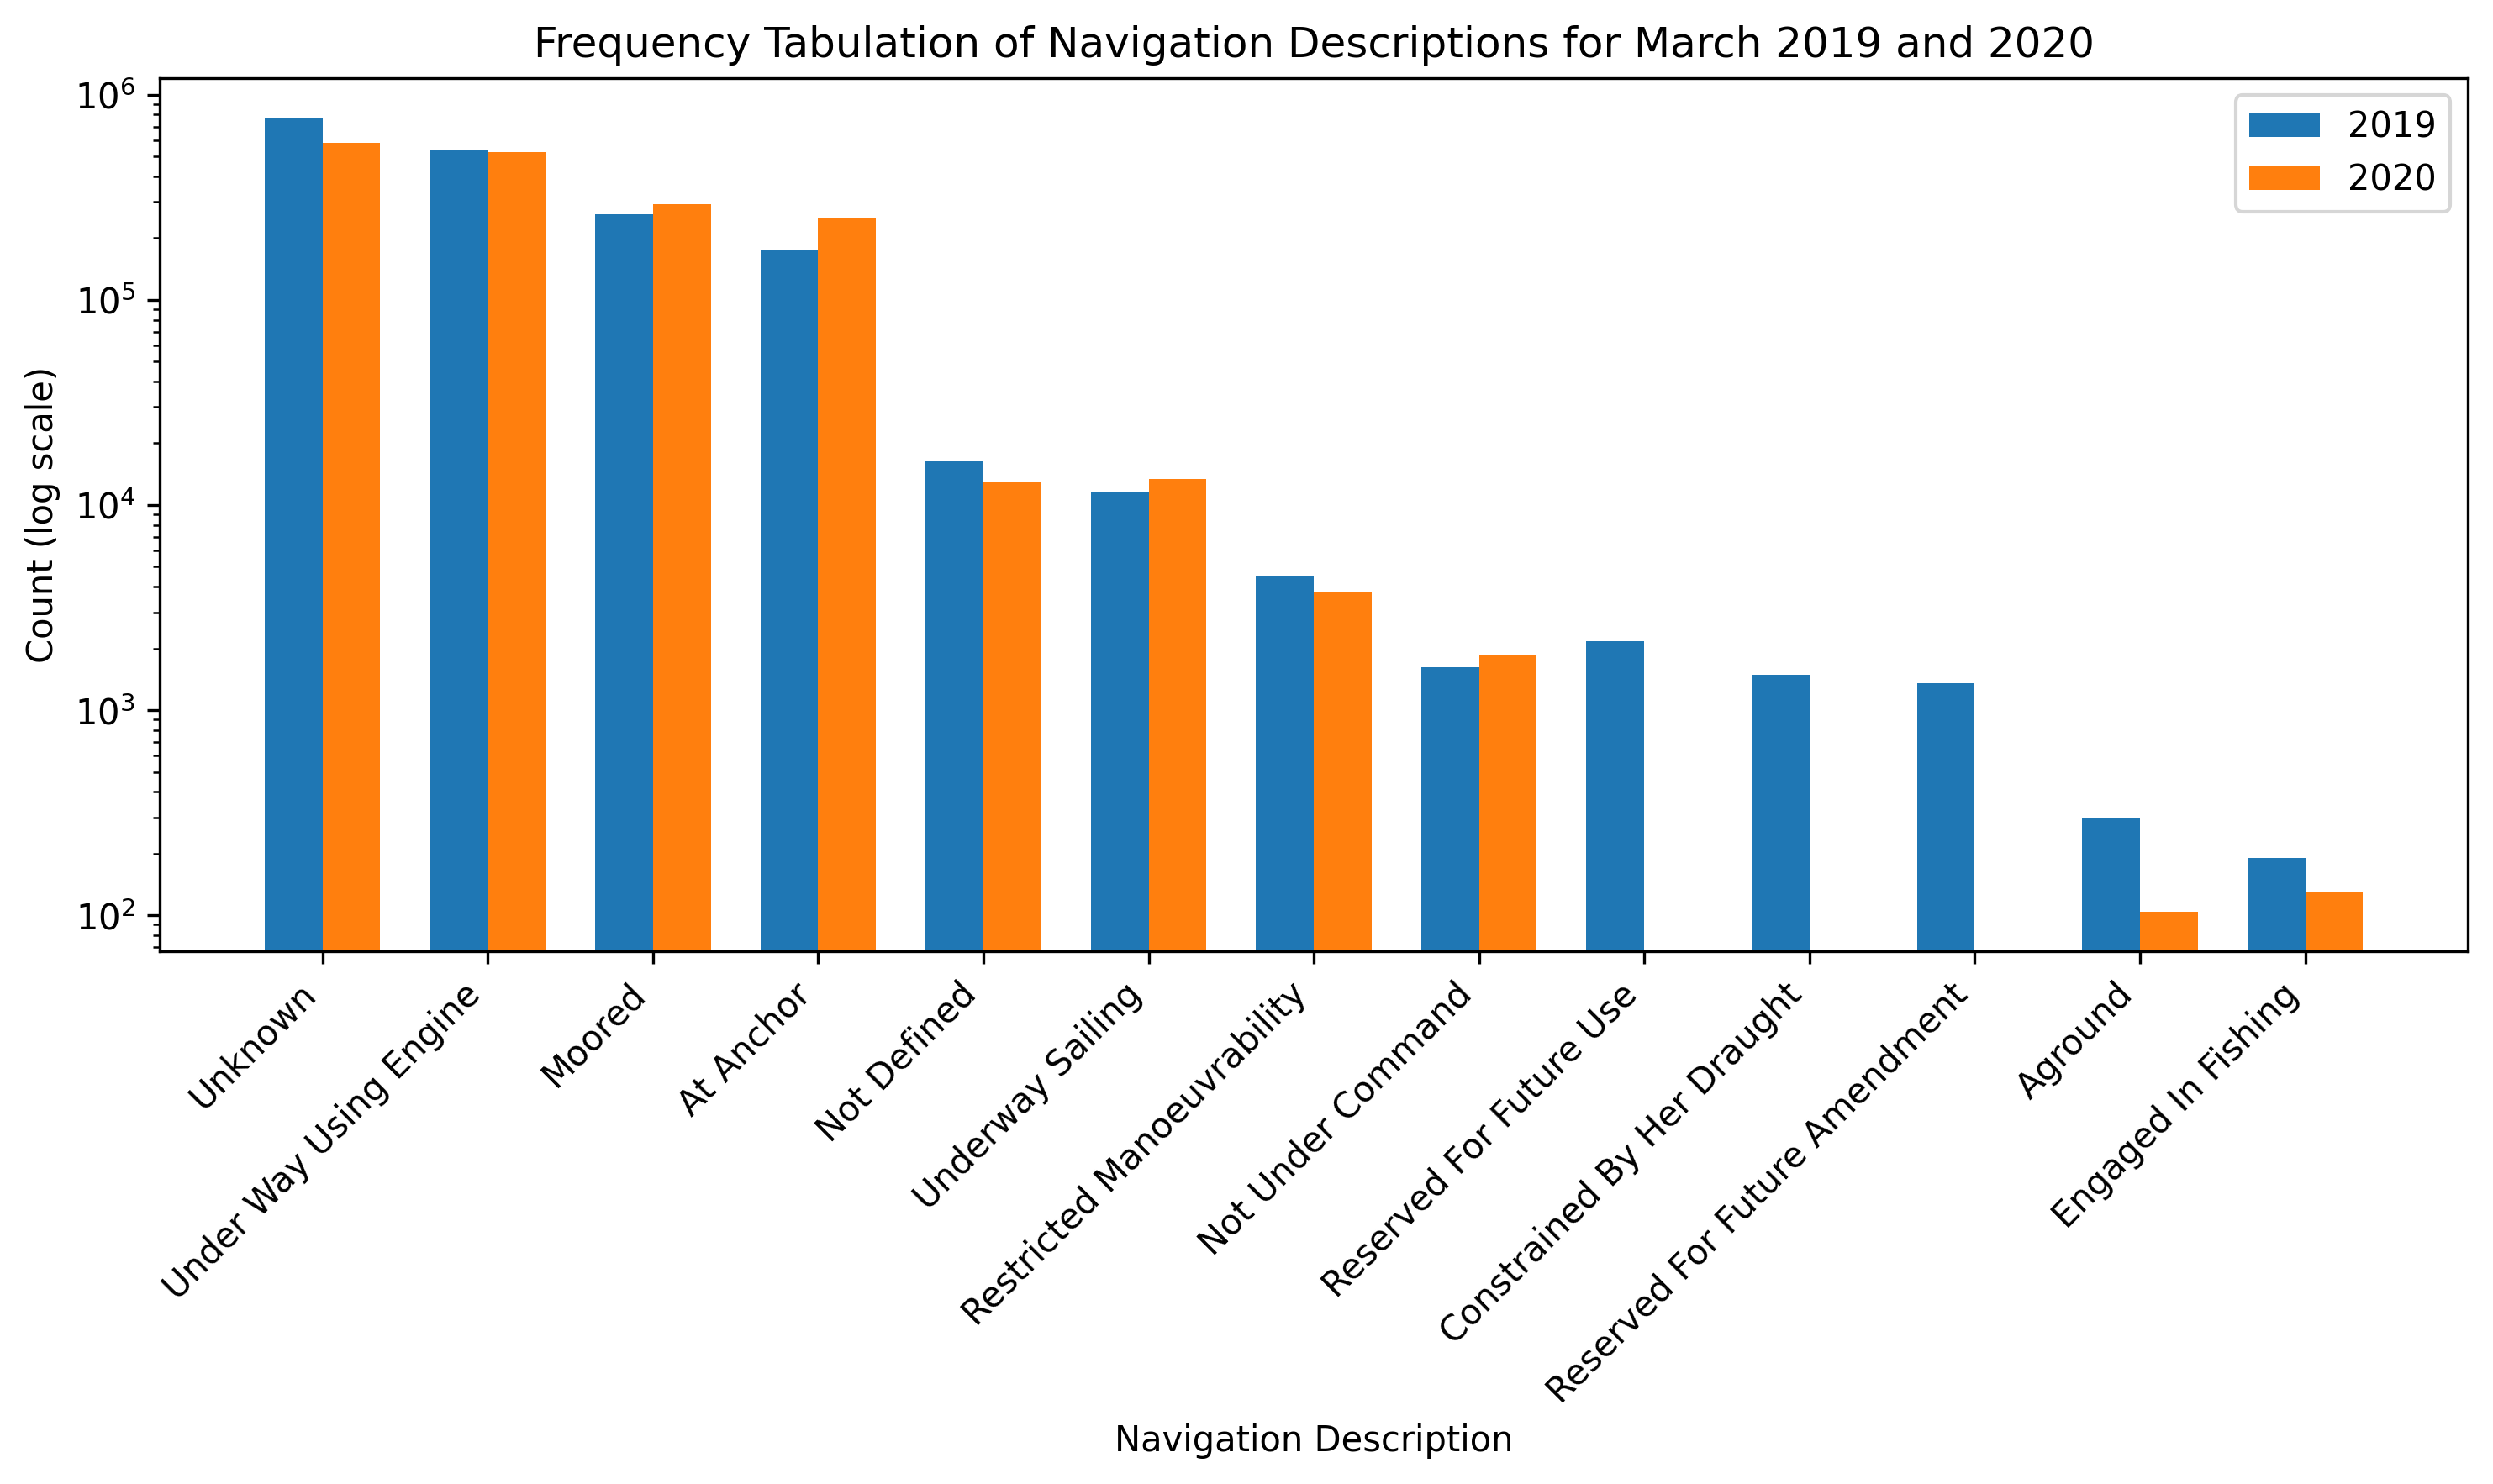

In [117]:
import matplotlib.pyplot as plt
import numpy as np

combined_years = pd.concat([df_2019, df_2020])

nav_code_desc_counts = combined_years.groupby(['navCode', 'navDesc', 'year']).size().reset_index(name='count')
unique_nav_code_desc_counts = nav_code_desc_counts.groupby(['navDesc', 'year'])['count'].sum().reset_index()
pivot_df = unique_nav_code_desc_counts.pivot(index='navDesc', columns='year', values='count').fillna(0)
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total', ascending=False).drop(columns='total')


labels = pivot_df.index
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pivot_df[2019], width, label='2019')
bars2 = ax.bar(x + width/2, pivot_df[2020], width, label='2020')

ax.set_xlabel('Navigation Description')
ax.set_ylabel('Count (log scale)')
ax.set_title('Frequency Tabulation of Navigation Descriptions for March 2019 and 2020')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

ax.set_yscale('log')

fig.tight_layout()
fig.set_dpi(300)
plt.show()

##### *11. For each of the time period(s) from item three and using only the “At Anchor” and “Moored” navigation descriptions, quantify the average “dwell”*

In [120]:
combined_df = combined_df[['mmsi', 'navCode', 'navDesc', 'timestamp', 'year', 'epochMillis']]
filtered_df = combined_df[combined_df['navCode'].isin([1,5])]

df_2019 = filtered_df[filtered_df['year'] == 2019]
df_2020 = filtered_df[filtered_df['year'] == 2020]

In [124]:
def calculate_dwell_time(df):
    df = df.sort_values(by=['mmsi', 'timestamp'])
    df['dwell_time'] = df.groupby('mmsi')['timestamp'].diff().shift(-1)
    df['dwell_time'] = df['dwell_time'].fillna(pd.Timedelta(seconds=0))
    return df

dwell_2019 = calculate_dwell_time(df_2019)
dwell_2020 = calculate_dwell_time(df_2020)

In [131]:
avg_dwell_2019, avg_dwell_2020 = (dwell_2019.groupby('navDesc')['dwell_time'].mean(), 
                                dwell_2020.groupby('navDesc')['dwell_time'].mean())

In [162]:
def get_avg_dwell_time(avg_dwell_times, year):
    dwell_times = {}
    print(f"Average Dwell Time for March {year}:")
    for navDesc, dwell_time in avg_dwell_times.items():
        # Convert to minutes
        total_minutes = dwell_time.total_seconds() / 60
        dwell_times[navDesc] = total_minutes
        print(f"{navDesc}: {total_minutes:.2f} minutes")
    return dwell_times

In [163]:
avg_dwell_2019 = get_avg_dwell_time(avg_dwell_2019, 2019)
print()
avg_dwell_2020 = get_avg_dwell_time(avg_dwell_2020, 2020)

Average Dwell Time for March 2019:
At Anchor: 28.56 minutes
Moored: 27.31 minutes

Average Dwell Time for March 2020:
At Anchor: 28.45 minutes
Moored: 26.50 minutes


##### *12. Describe or show how you would quantify if the difference(s) in “dwells” between the time-period(s) is(are) significant.*


To determine if the differences in dwell times between the periods 2019 and 2020 are statistically significant, we can perform an independent two-sample t-test. This test compares the means of two independent samples to see if they are from populations with different means.

Our null-hypothesis is that there is NO significant difference between these samples. Depending on the p-value, we either reject a null-hypothesis (if p-value < $\alpha$) or are unable to reject it (when p-value > $\alpha$). We'll align to the common practise and set $\alpha = 0.05$.

In [166]:
from scipy.stats import ttest_ind

In [196]:
anchor_2019 = dwell_2019[dwell_2019['navCode'] == 1]['dwell_time'].dt.total_seconds().tolist()
anchor_2020 = dwell_2020[dwell_2020['navCode'] == 1]['dwell_time'].dt.total_seconds().tolist()

ttest_ind(anchor_2019, anchor_2020)

TtestResult(statistic=np.float64(0.23368560980805317), pvalue=np.float64(0.8152291723609022), df=np.float64(426431.0))

As a result, in case of Anchored vessels, we cannot reject the null-hypothesis, since p-value is about 0.82, which is greater than 0.05. Therefore, we conclude that the difference between dwell times is insignificant here (which makes sense, since the difference between averages was less than a half of a minute). 

In [197]:
moor_2019 = dwell_2019[dwell_2019['navCode'] == 5]['dwell_time'].dt.total_seconds().tolist()
moor_2020 = dwell_2020[dwell_2020['navCode'] == 5]['dwell_time'].dt.total_seconds().tolist()

ttest_ind(moor_2019, moor_2020)

TtestResult(statistic=np.float64(2.1262871224178532), pvalue=np.float64(0.033479800367833074), df=np.float64(554131.0))

For moored vessels, however, the difference is likely to be significant, because the p-value < 0.05. We can then reject the null-hypothesis and conclude that the difference is significant. This also makes sense, because the difference between the averages was much higher than in cased of anchored vessels.